# Time Headway Calculator

The goal of this notebook is to establish time headways for individual following events, as a histogram based on the speed of the following vehicle.

Authors: Sally Kim, Jonathan Sprinkle

In [93]:
import signal
import pandas as pd
import sys, math, time, datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
from matplotlib.pyplot import cm
import pickle
from strym import strymread
import strym
import copy

In [95]:
# change this to your data folder
# datafolder='/Users/sallykim/Desktop/2021_08_09/'
datafolder='/Users/sprinkle/work/data/sally/2021_08_09/'
# datafolder='/Users/sallykim/Desktop/2021_08_09/'

import glob
csvlist = glob.glob(datafolder+"*2T3*CAN*.csv")

num_of_files = len(csvlist)
print("Total number of datafiles in {} is {}.".format(datafolder, num_of_files))
# dbcfile = '../examples/newToyotacode.dbc'

Total number of datafiles in /Users/sprinkle/work/data/sally/2021_08_09/ is 3.


In [96]:
# choose the first file, and then plot the speed, as well as the lead vehicle distance
# Look in Minitest 1 or in 

#dbcfile_17 = '/Users/sallykim/opt/miniconda3/lib/python3.9/site-packages/strym/dbc/toyota_rav4_hybrid.dbc'
datafile_17 = datafolder+'2021-08-09-17-42-45_2T3Y1RFV8KC014025_CAN_Messages.csv'
#data_17 = pd.read_csv(datafile_17)


In [97]:
r0 = strymread(datafile_17)
speed = r0.speed()
try:
    speed_17 = r0.get_ts('SPEED','SPEED')
    long_dist_17 = r0.get_ts('LEAD_INFO','LEAD_LONG_DIST')
    long_dist_17_2 = r0.lead_distance()
except:
    print('Oops, a specific error message Sally writes')

[2022_07_19_16_12_40] (root) INFO: Vehicle model infered is toyota-rav4-2019


[Text(0.5, 94.72222222222219, 'Time (s) from start of drive'),
 Text(135.47222222222223, 0.5, 'Lead vehicle longitudinal distance (m)'),
 Text(0.5, 1.0, 'Lead Distance vs. Time')]

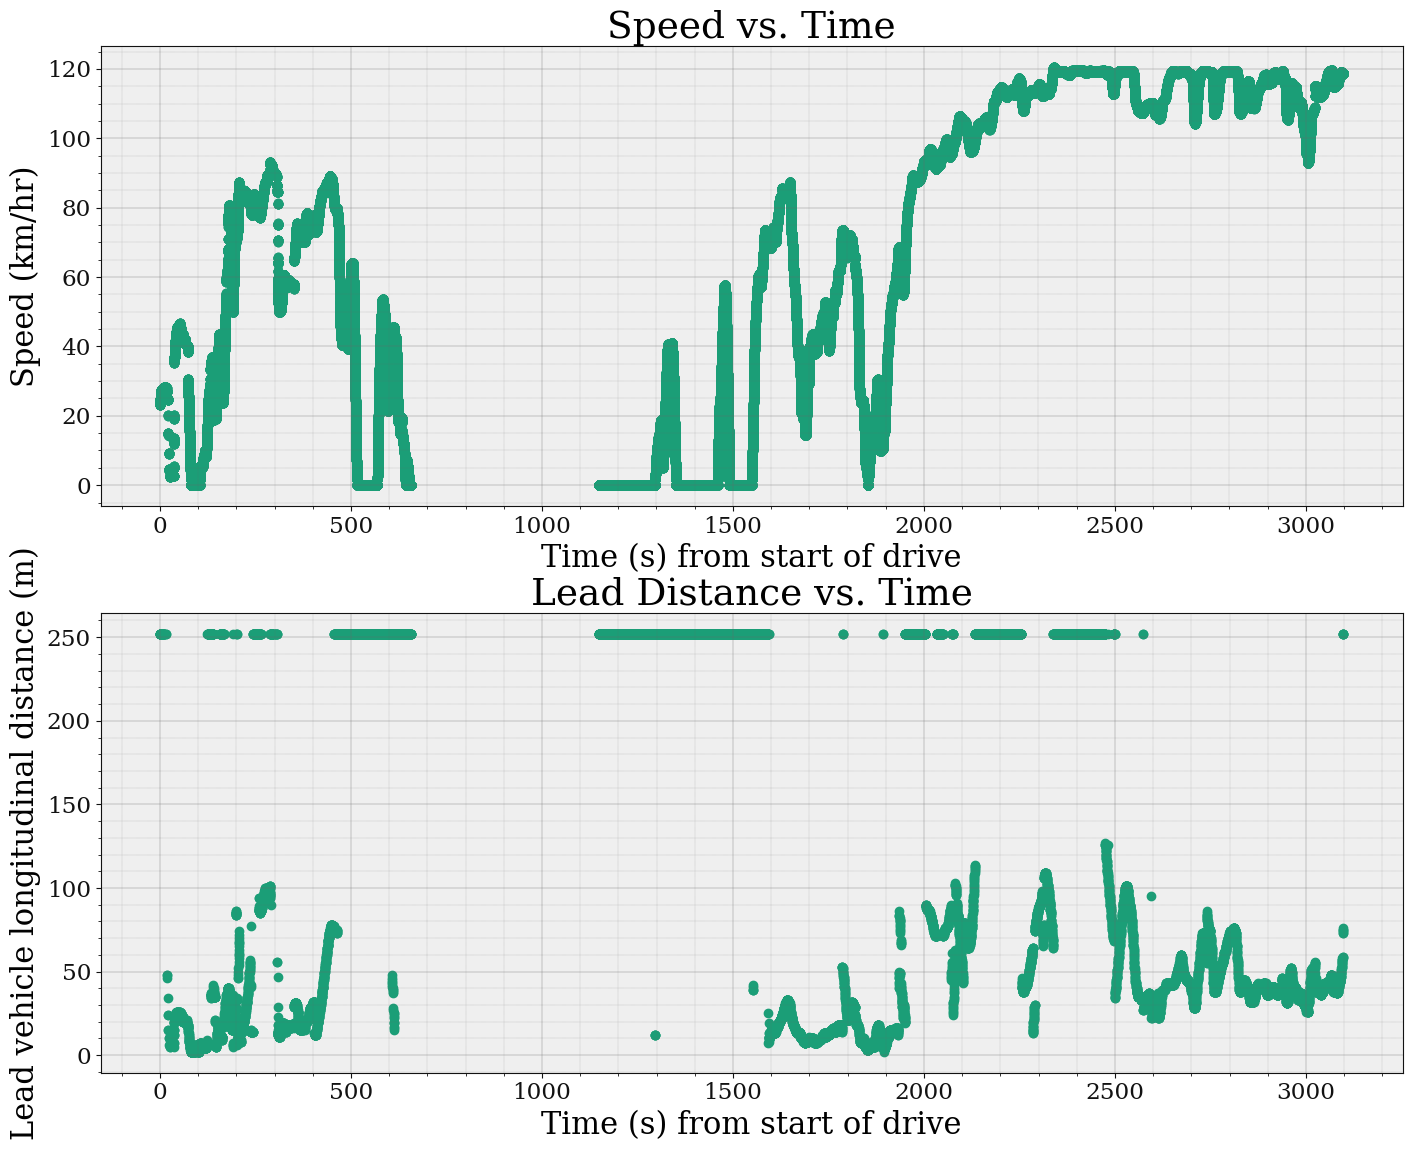

In [98]:
# choose the first file, and then plot the speed, as well as the lead vehicle distance
# Look in Minitest 1 or in 
fig, ax = strymread.create_fig(2)
ax[0].scatter(x=speed_17['Time'] - speed_17['Time'][0],y=speed_17['Message'])
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr)',title='Speed vs. Time')
ax[1].scatter(x=long_dist_17_2['Time'] - long_dist_17_2['Time'][0],y=long_dist_17_2['Message'])
ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')

In [99]:
# find all times where the lead vehicle distance changes by more than 5

# 1. we're going to remove all times where we have >250 m and create chunks of data
lead_dist = long_dist_17_2
lead_dist_f = lead_dist[lead_dist["Message"]<200]

[Text(0.5, 94.72222222222219, 'Time (s) from start of drive'),
 Text(135.47222222222223, 0.5, 'Lead vehicle longitudinal distance (m)'),
 Text(0.5, 1.0, 'Lead Distance vs. Time')]

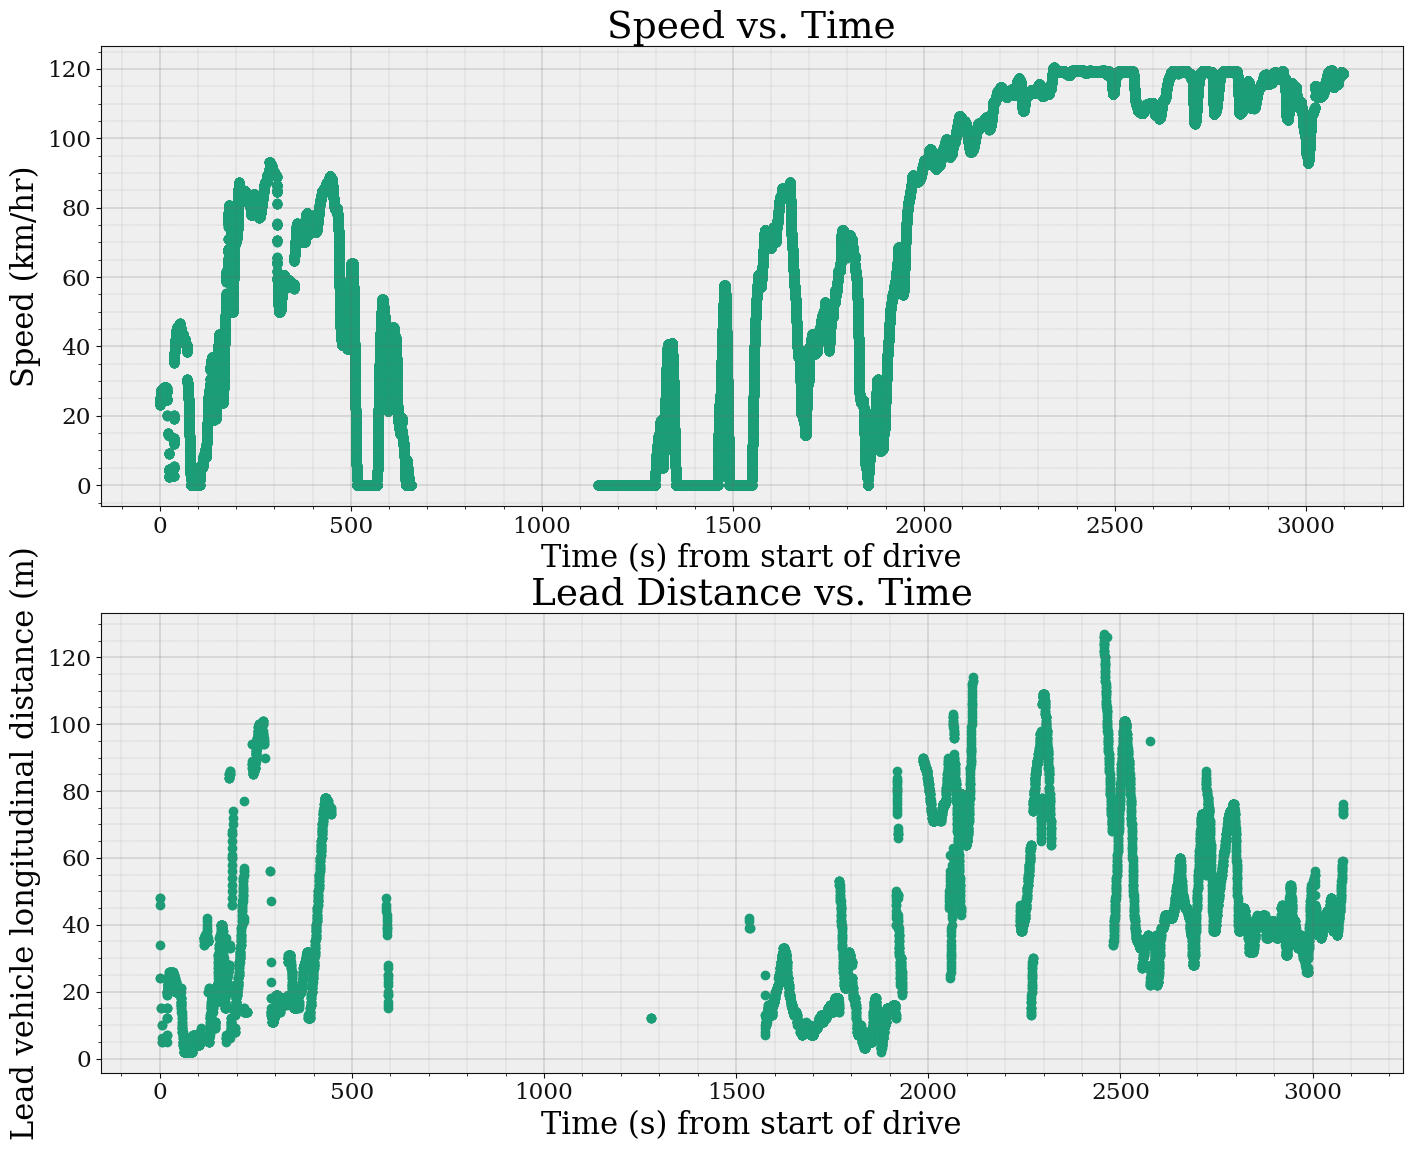

In [100]:
fig, ax = strymread.create_fig(2)
ax[0].scatter(x=speed_17['Time'] - speed_17['Time'][0],y=speed_17['Message'])
ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr)',title='Speed vs. Time')
ax[1].scatter(x=lead_dist_f['Time'] - lead_dist_f['Time'][0],y=lead_dist_f['Message'])
ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')

In [101]:
lead_dist_chunks = strymread.create_chunks(
        lead_dist_f,
        # look for any 'big' differences from time to time
        continuous_threshold=5,
        column_of_interest='Message',
#        plot=True,
    )

# now, remove any values where the duration of this chunk is less than 5 seconds
min_duration = 5
lead_dist_chunks_copy = lead_dist_chunks
for jj in reversed(range(len(lead_dist_chunks_copy))):
    chunk = lead_dist_chunks[jj]
    duration = chunk.Time[-1] - chunk.Time[0]
    if duration < min_duration:
        print('Removing element of duration ', duration)
        lead_dist_chunks.pop(jj)
    else:
        print('Keeping element of duration ', duration)

print('We now have ', len(lead_dist_chunks), ' drives that are longer than ', min_duration, ' seconds')

Removing element of duration  0.9994959831237793
Keeping element of duration  356.21048617362976
Keeping element of duration  127.80330801010132
Keeping element of duration  16.200128078460693
Removing element of duration  0.0
Keeping element of duration  21.001094102859497
Keeping element of duration  74.00198817253113
Keeping element of duration  14.200394868850708
Removing element of duration  0.0
Keeping element of duration  7.8005499839782715
Keeping element of duration  23.60106110572815
Removing element of duration  4.000278949737549
Keeping element of duration  20.20098900794983
Removing element of duration  4.60017204284668
Keeping element of duration  29.40112614631653
Keeping element of duration  30.374499082565308
Keeping element of duration  21.000452995300293
Keeping element of duration  6.000230073928833
Removing element of duration  3.0703799724578857
Keeping element of duration  66.4016969203949
Removing element of duration  4.40029501914978
Keeping element of duration

In [102]:
# next step: let's divide these up (if you can) OR you can instead try to calculate the time headway across these.
# to do that:
# 1) create a resampled version of two different timeseries
# e.g.,
# val1_sampled, val2_sampled = strymread.ts_sync(ts_val1, ts_val2)
speed = speed_17
lead_dist = lead_dist_chunks

result_speed = []
result_lead_dist = []
result_time_headway = []
time_headway = pd.DataFrame()

for lead_dist in lead_dist_chunks:
    speed_s, lead_dist_s = strymread.ts_sync(speed,lead_dist, method='nearest')
    result_speed.append(speed_s)
    # look for an exmaple where someone creates a new signal based on math with individual messages
    result_lead_dist.append(lead_dist_s)
    time_headway = speed_s[['Time','Message']].copy()
    time_headway['Message'] = lead_dist_s['Message'] / speed_s['Message']
    result_time_headway.append(time_headway)
# 2) divide the distance by the velocity to come up with the time headway
print( 'len(result_speed)=', len(result_speed), ', len(result_lead_dist)=', len(result_lead_dist), ', time headway = ', (len(result_time_headway)))


len(result_speed)= 29 , len(result_lead_dist)= 29 , time headway =  29


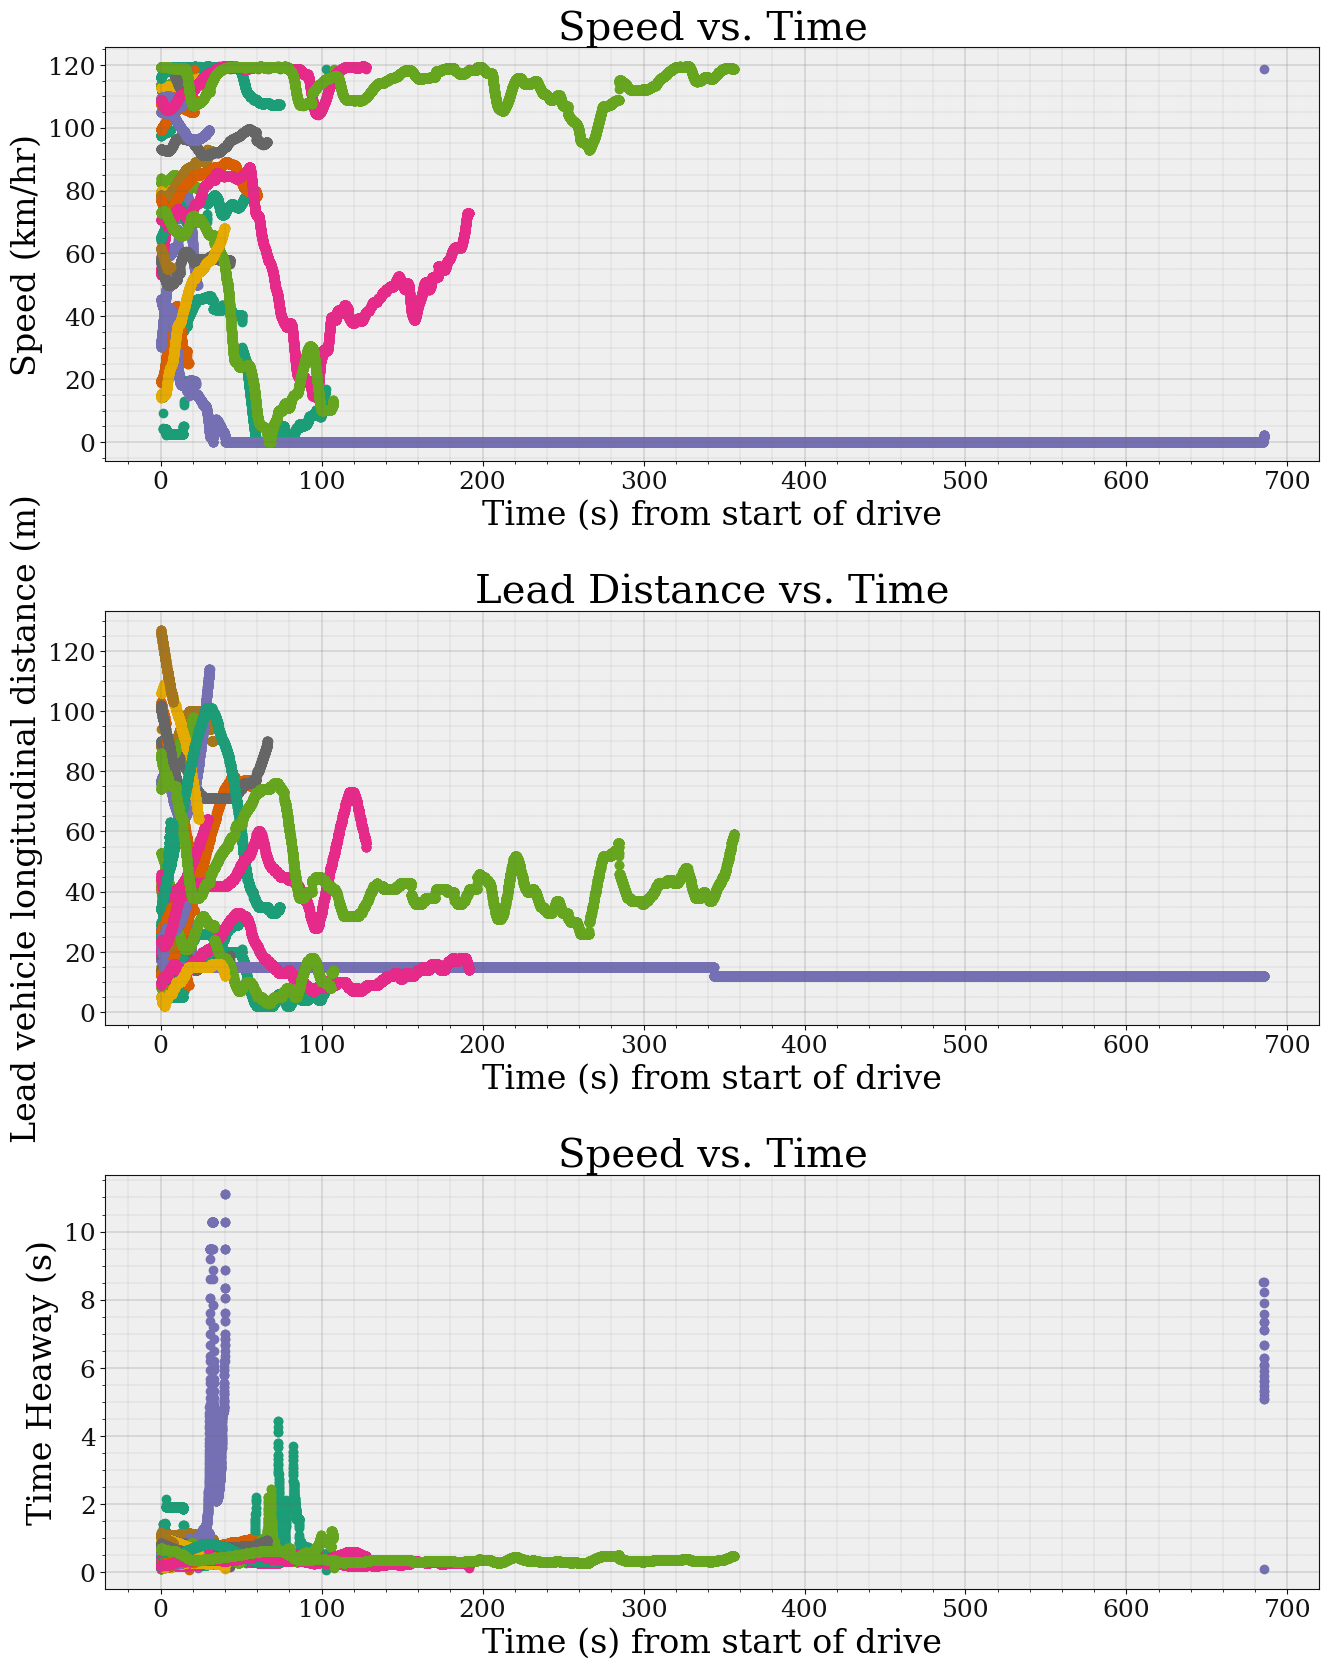

In [103]:
fig, ax = strymread.create_fig(3)
for jj in range(len(result_lead_dist)):
    ax[0].scatter(x=result_speed[jj]['Time'] - result_speed[jj]['Time'][0],y=result_speed[jj]['Message'])
    ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr)',title='Speed vs. Time')
    ax[1].scatter(x=result_lead_dist[jj]['Time'] - result_lead_dist[jj]['Time'][0],y=result_lead_dist[jj]['Message'])
    ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')
    ax[2].scatter(x=result_time_headway[jj]['Time'] - result_time_headway[jj]['Time'][0],y=result_time_headway[jj]['Message'])
    ax[2].set(xlabel='Time (s) from start of drive',ylabel='Time Heaway (s)',title='Speed vs. Time')

In [104]:
# remove all times where the lead vehicle distance is > 200

In [122]:
# print(result_speed)

In [131]:
r0_v = []
r1_v = []

for chunk in result_speed:
    region0 = chunk[(chunk['Message'] > 40) & (chunk['Message'] < 60)]
    # only save it if it has nonzero length
    if len(region0) > 0:
        r0_v.append(region0)
    

At this point, you have figured out the times that make sense for velocity, but we have an array of those times, and there is a similar array of the other data (like lead vehicle distance), so we don't know where we are in each array unless we iterate over them all. So---we can either track 3 different iterators /or/ we can make a function that returns the values we want, based on the time values we have.

In [140]:
# pass in the ENTIRE lead distance info, and then the speed dataframes for times where you want time headway.
# then it returns the time headway
def time2timeheadway(lead_dist_all,speed_subset):
    speed_s, lead_dist_s = strymread.ts_sync(speed_subset,lead_dist_all, method='previous')
    time_headway = speed_s[['Time','Message']].copy()
    time_headway['Message'] = lead_dist_s['Message'] / speed_s['Message']
    return time_headway, lead_dist_s

It looks like we're able to get those values now. Let's now iterate over ALL of the values by speed iteration.

In [141]:
th0 = []
ld0 = []

for speed in r0_v:
#     region0 = time_headway[time_headway['Time'] == time['Time']]
#     region0 = time_headway.loc[time['Time']]
#     th0.append(region0)  
#     print(region0)
    th, ld = time2timeheadway(long_dist_17_2, speed)
    th0.append(th)
    ld0.append(ld)

In [145]:
def plotDetails(speeds,lead_dists,time_headways):
    fig, ax = strymread.create_fig(3)
    for jj in range(len(lead_dists)):
        ax[0].scatter(x=speeds[jj]['Time'] - speeds[jj]['Time'][0],y=speeds[jj]['Message'])
        ax[0].set(xlabel='Time (s) from start of drive',ylabel='Speed (km/hr)',title='Speed vs. Time')
        ax[1].scatter(x=lead_dists[jj]['Time'] - lead_dists[jj]['Time'][0],y=lead_dists[jj]['Message'])
        ax[1].set(xlabel='Time (s) from start of drive',ylabel='Lead vehicle longitudinal distance (m)',title='Lead Distance vs. Time')
        ax[2].scatter(x=time_headways[jj]['Time'] - time_headways[jj]['Time'][0],y=time_headways[jj]['Message'])
        ax[2].set(xlabel='Time (s) from start of drive',ylabel='Time Headway (s)',title='Time Headway')

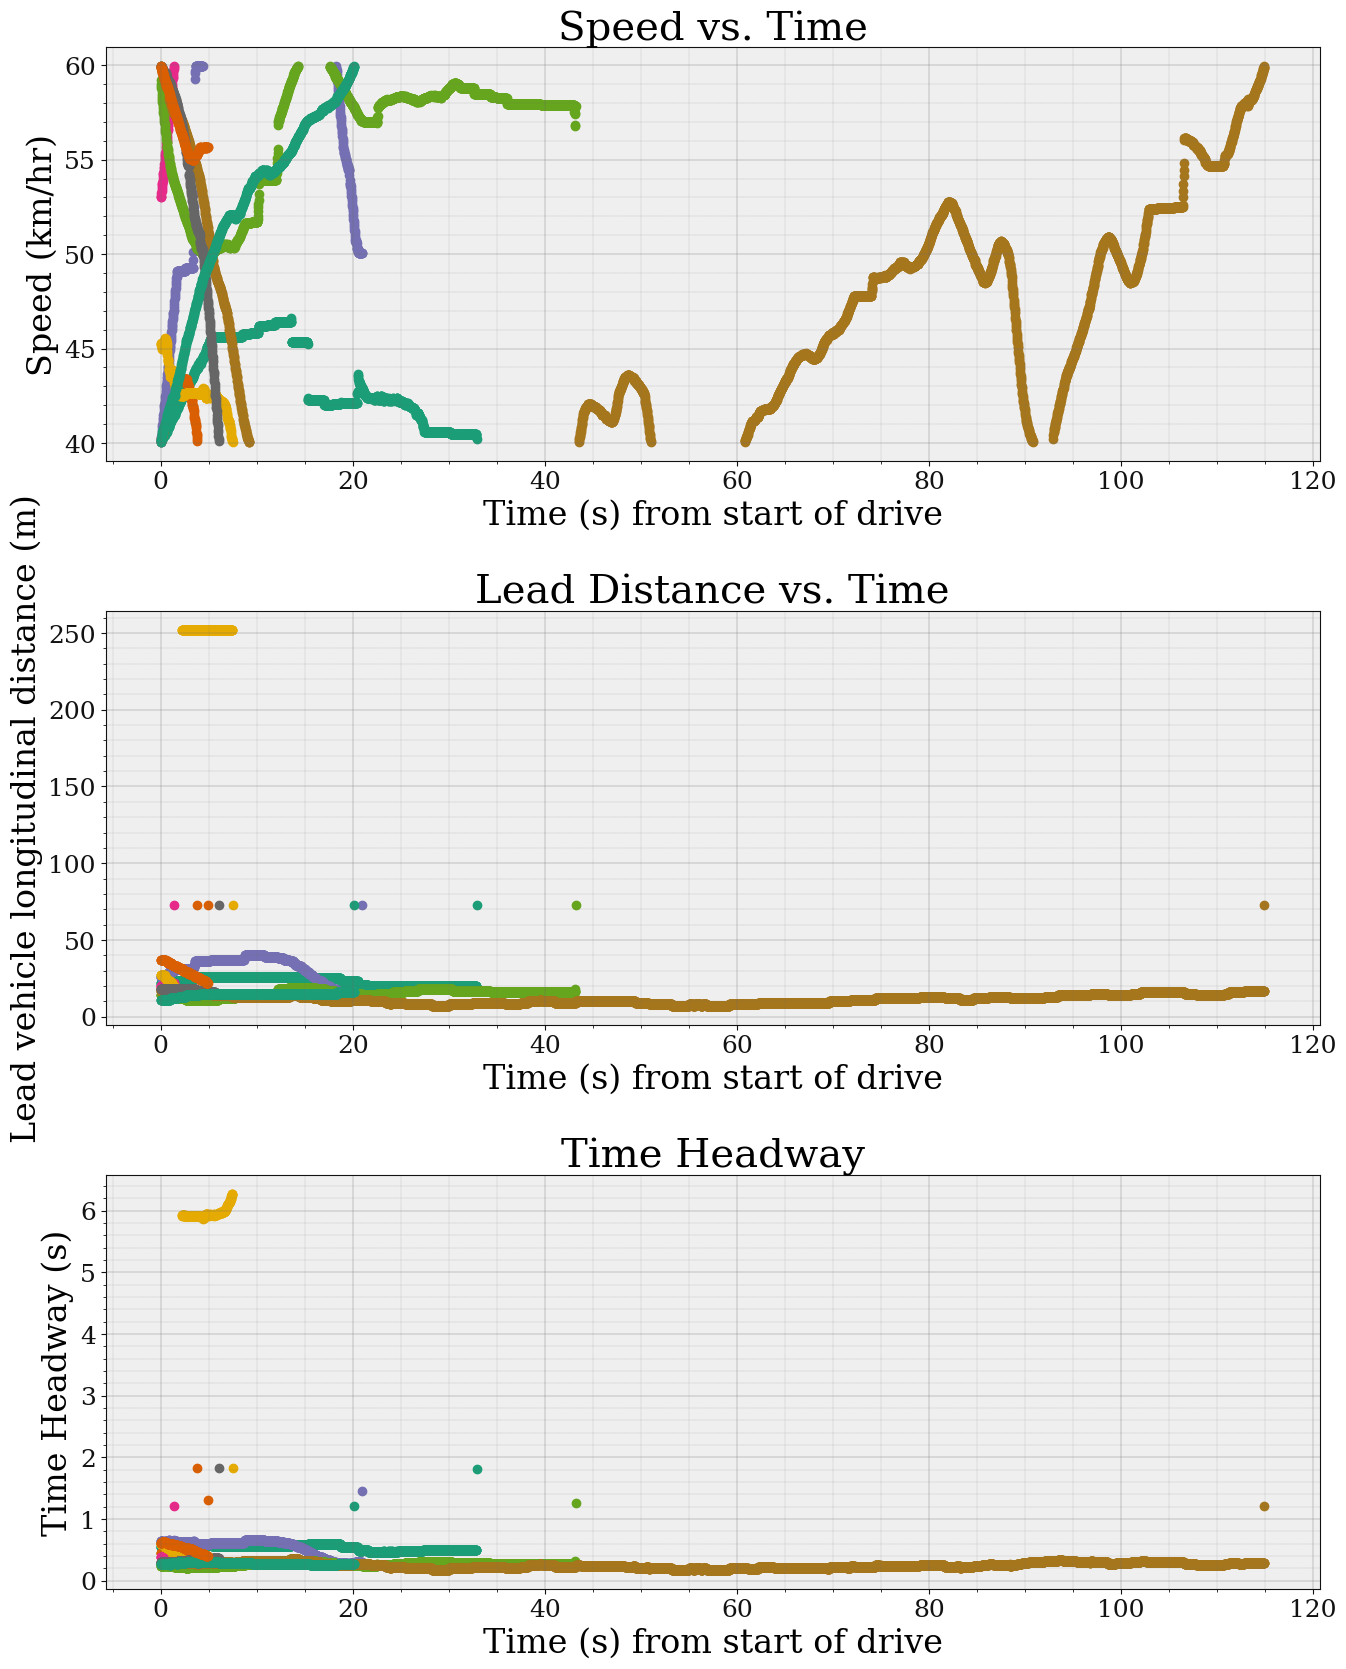

In [147]:
plotDetails(r0_v,ld0,th0)